# 실종 강아지 현재 모습 예측 프로젝트 - Age-cGAN 훈련

이 노트북은 DogAge 데이터셋을 사용하여 강아지의 나이 변화를 예측하는 Age-conditional GAN 모델을 훈련합니다.

## 프로젝트 개요
- **목적**: 실종된 강아지의 현재 모습을 예측하여 찾기 쉽게 돕기
- **모델**: Age-conditional GAN (Age-cGAN)
- **데이터**: Kaggle DogAge Dataset (27.3k 이미지, 3개 연령 그룹)
- **연령 그룹**: Young (어린 강아지), Adult (성견), Senior (노견)

## 필요 조건
- Google Colab GPU 런타임
- Kaggle API 계정 및 kaggle.json 파일
- 약 2-3시간의 훈련 시간

## 1. 환경 설정 및 라이브러리 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# GPU 사용 가능 여부 확인
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import inception_v3
import torchvision.models as models


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 디바이스: {device}')

if torch.cuda.is_available():
    print(f'GPU 이름: {torch.cuda.get_device_name(0)}')
    print(f'GPU 메모리: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB')

사용 중인 디바이스: cuda
GPU 이름: Tesla T4
GPU 메모리: 14 GB


In [3]:
# 필요한 라이브러리 설치
!pip install kaggle
!pip install opencv-python-headless
!pip install pillow
!pip install matplotlib
!pip install tqdm
!pip install tensorboard

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import random
from datetime import datetime
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

# 시드 설정 (재현성을 위해)
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
import os

DATA_PATH = '/content/drive/MyDrive/Dog_Image_Generator/dataset/'

if not os.path.exists(DATA_PATH):
    print(f"오류: '{DATA_PATH}' 경로를 찾을 수 없습니다. 경로를 올바르게 설정했는지 확인해주세요.")
else:
    print(f"데이터셋 경로가 '{DATA_PATH}'로 설정되었습니다.")
    # 실제 존재하는 하위 폴더 목록을 출력합니다.
    print("존재하는 하위 폴더:", [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])


데이터셋 경로가 '/content/drive/MyDrive/Dog_Image_Generator/dataset/'로 설정되었습니다.
존재하는 하위 폴더: ['Expert_Train', 'PetFinder_All']


## 2. Kaggle API 설정 및 데이터셋 다운로드

## 3. 데이터셋 분석 및 전처리

In [ ]:
# import zipfile
# import os
# from tqdm import tqdm  # 진행 바를 보여주는 라이브러리

# zip_path = '/content/drive/MyDrive/Dog_Image_Generator/dataset/the-dogage-dataset.zip'
# extract_path = '/content/drive/MyDrive/Dog_Image_Generator/dataset'

# # 압축 해제 진행 상황 출력
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     file_list = zip_ref.namelist()  # 압축 안의 모든 파일 목록

#     for file in tqdm(file_list, desc="압축 해제 중"):
#         zip_ref.extract(member=file, path=extract_path)

# print("압축 해제 완료!")


In [9]:
# 데이터셋 구조 탐색
def explore_dataset_structure(root_path):
    print("=== 데이터셋 구조 분석 ===")

    for root, dirs, files in os.walk(root_path):
        level = root.replace(root_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")

        subindent = ' ' * 2 * (level + 1)

        # 이미지 파일만 카운트
        img_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if img_files:
            print(f"{subindent}이미지 파일: {len(img_files)}개")
            if len(img_files) <= 5:
                for f in img_files[:5]:
                    print(f"{subindent}- {f}")
            else:
                for f in img_files[:3]:
                    print(f"{subindent}- {f}")
                print(f"{subindent}... 그 외 {len(img_files)-3}개")

explore_dataset_structure(DATA_PATH)

=== 데이터셋 구조 분석 ===
/
Expert_Train/
  Expert_TrainEval/
    Adult/
      이미지 파일: 370개
      - American bulldog 2-5 M copy.jpg
      - Akita 2-5 M copy.jpg
      - Beagle 2-5 M.png
      ... 그 외 367개
    Senior/
      이미지 파일: 495개
      - Akita 5-7 F copy.jpg
      - Akita 5-7 M copy.jpg
      - Akita 8+ M.png
      ... 그 외 492개
    Young/
      이미지 파일: 223개
      - Akita 2.5 F.png
      - Akita 1-2 M.jpg
      - American bulldog 1-2 F (1) copy.jpg
      ... 그 외 220개
PetFinder_All/
  PetFinder_All/
    Adult/
      이미지 파일: 15083개
      - 43705626_2.jpg
      - 43705626_1.jpg
      - 43705626_3.jpg
      ... 그 외 15080개
    Senior/
      이미지 파일: 2233개
      - 43190097_1.jpg
      - 43190097_2.jpg
      - 43190097_3.jpg
      ... 그 외 2230개
    Young/
      이미지 파일: 8874개
      - 43679324_1.jpg
      - 43679487_2.jpg
      - 43680314_1.jpg
      ... 그 외 8871개


In [10]:
# 각 연령 그룹별 이미지 개수 확인
def count_images_by_age_group(data_path):
    age_groups = ['Young', 'Adult', 'Senior']
    counts = {}

    # Expert 데이터와 PetFinder 데이터 모두 확인
    for dataset_type in ['Expert_Train/Expert_TrainEval', 'PetFinder_All/PetFinder_All']:
        dataset_path = os.path.join(data_path, dataset_type)
        if os.path.exists(dataset_path):
            counts[dataset_type] = {}
            print(f"\n=== {dataset_type} 데이터셋 ===")

            for age_group in age_groups:
                age_path = os.path.join(dataset_path, age_group)
                if os.path.exists(age_path):
                    img_files = [f for f in os.listdir(age_path)
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    counts[dataset_type][age_group] = len(img_files)
                    print(f"{age_group}: {len(img_files)}개 이미지")
                else:
                    counts[dataset_type][age_group] = 0
                    print(f"{age_group}: 폴더 없음")

    return counts

image_counts = count_images_by_age_group(DATA_PATH)


=== Expert_Train/Expert_TrainEval 데이터셋 ===
Young: 223개 이미지
Adult: 370개 이미지
Senior: 495개 이미지

=== PetFinder_All/PetFinder_All 데이터셋 ===
Young: 8874개 이미지
Adult: 15083개 이미지
Senior: 2233개 이미지


In [11]:
from collections import defaultdict

def count_files_by_extension(path):
    ext_counts = defaultdict(int)
    for root, dirs, files in os.walk(path):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            ext_counts[ext] += 1
    return dict(ext_counts)

# 사용
directory_path = '/content/drive/MyDrive/Dog_Image_Generator/dataset/'
counts = count_files_by_extension(directory_path)
for ext, count in counts.items():
    print(f"{ext}: {count}개")


.jpg: 26980개
.png: 298개


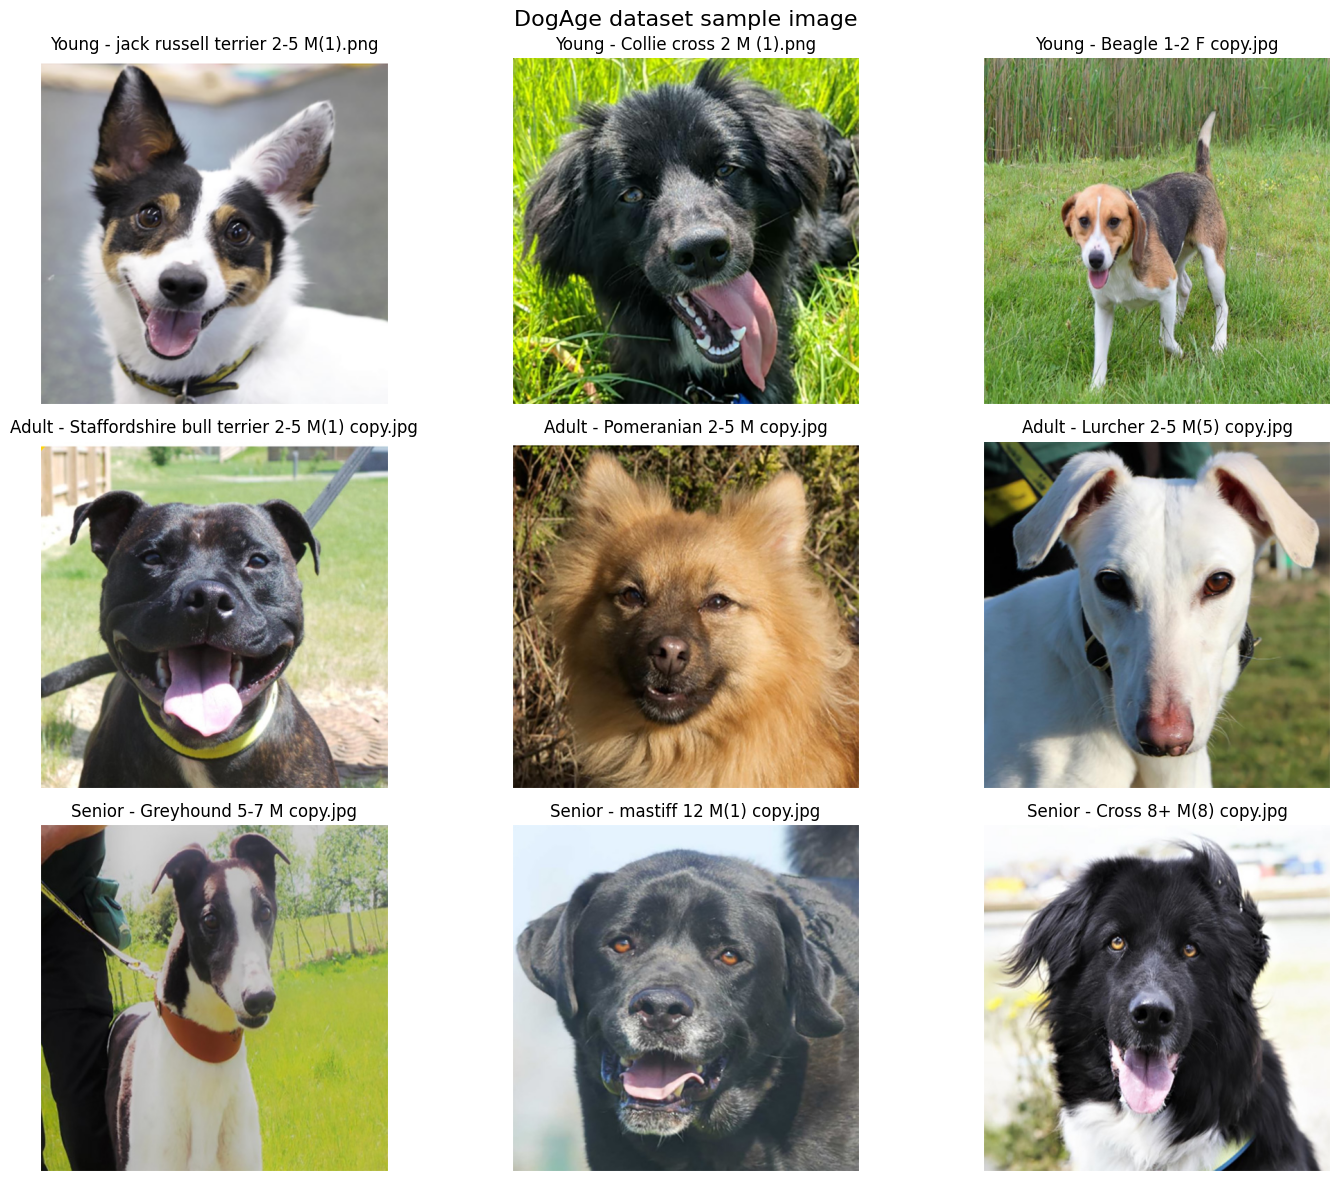

In [12]:
# 샘플 이미지 시각화
def visualize_sample_images(data_path, num_samples=3):
    age_groups = ['Young', 'Adult', 'Senior']

    fig, axes = plt.subplots(len(age_groups), num_samples, figsize=(15, 12))
    fig.suptitle('DogAge dataset sample image', fontsize=16)

    for i, age_group in enumerate(age_groups):
        # Expert 데이터에서 샘플 가져오기
        age_path = os.path.join(data_path, 'Expert_Train/Expert_TrainEval', age_group)
        if os.path.exists(age_path):
            img_files = [f for f in os.listdir(age_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if len(img_files) >= num_samples:
                selected_files = random.sample(img_files, num_samples)

                for j, img_file in enumerate(selected_files):
                    img_path = os.path.join(age_path, img_file)
                    img = Image.open(img_path)

                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f'{age_group} - {img_file}')
                    axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_images(DATA_PATH)

## 4. 커스텀 데이터셋 클래스 정의

In [13]:
class DogAgeDataset(Dataset):
    def __init__(self, data_path, transform=None, use_expert_only=True, image_size=128):
        self.data_path = data_path
        self.transform = transform
        self.image_size = image_size

        # 연령 그룹을 숫자로 매핑
        self.age_to_idx = {'Young': 0, 'Adult': 1, 'Senior': 2}
        self.idx_to_age = {v: k for k, v in self.age_to_idx.items()}

        self.images = []
        self.labels = []

        # 데이터 로딩
        self._load_data(use_expert_only)

        print(f"총 {len(self.images)}개의 이미지를 로딩했습니다.")
        print(f"연령 그룹별 분포: {self._get_class_distribution()}")

    def _load_data(self, use_expert_only):
        datasets = ['Expert_Train/Expert_TrainEval'] if use_expert_only else ['Expert_Train/Expert_TrainEval', 'PetFinder_All/PetFinder_All']

        for dataset_name in datasets:
            dataset_path = os.path.join(self.data_path, dataset_name)
            if not os.path.exists(dataset_path):
                continue

            for age_group in self.age_to_idx.keys():
                age_path = os.path.join(dataset_path, age_group)
                if not os.path.exists(age_path):
                    continue

                # 이미지 파일 리스트 가져오기
                img_files = [f for f in os.listdir(age_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

                for img_file in tqdm(img_files, desc=f'Loading {dataset_name}/{age_group}'):
                    img_path = os.path.join(age_path, img_file)

                    try:
                        # 이미지가 유효한지 확인
                        with Image.open(img_path) as img:
                            img.verify()

                        self.images.append(img_path)
                        self.labels.append(self.age_to_idx[age_group])
                    except Exception as e:
                        print(f"이미지 로딩 실패: {img_path}, 오류: {e}")
                        continue

    def _get_class_distribution(self):
        from collections import Counter
        counter = Counter(self.labels)
        return {self.idx_to_age[k]: v for k, v in counter.items()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # 이미지 로딩 및 전처리
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            # 기본 전처리
            image = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1] 범위로 정규화
            ])(image)

        return image, label

## 5. Age-cGAN 모델 아키텍처 정의

In [14]:
class SelfAttention(nn.Module):
    """ Self-attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

# Generator의 업샘플링을 위한 Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        )
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.leaky_relu(self.block(x) + self.shortcut(x))

class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=3, img_channels=3, img_size=128):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.age_embedding = nn.Embedding(num_classes, latent_dim)

        initial_size = img_size // 32 # 4
        self.fc = nn.Sequential(
            nn.Linear(latent_dim * 2, 1024 * initial_size * initial_size),
            nn.BatchNorm1d(1024 * initial_size * initial_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # U-Net 디코더 블록: in_channels는 skip feature의 채널 수를 더한 값
        self.up1 = ResidualBlock(1024 + 512, 512)  # 입력: 4x4, 출력: 8x8. skip_features[0] (s5)와 결합
        self.up2 = ResidualBlock(512 + 256, 256)   # 입력: 8x8, 출력: 16x16. skip_features[1] (s4)와 결합
        self.up3 = ResidualBlock(256 + 128, 128)   # 입력: 16x16, 출력: 32x32. skip_features[2] (s3)와 결합
        self.attn = SelfAttention(128)
        self.up4 = ResidualBlock(128 + 64, 64)     # 입력: 32x32, 출력: 64x64. skip_features[3] (s2)와 결합

        # 최종 출력 레이어
        self.final_up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64 + 64, 32, kernel_size=3, stride=1, padding=1, bias=False), # skip_features[4] (s1)와 결합
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, age_labels, skip_features):
        # 1. 잠재 벡터 z와 나이 레이블로 초기 입력 생성
        age_embed = self.age_embedding(age_labels)
        gen_input = torch.cat([z, age_embed], dim=-1)
        out = self.fc(gen_input)
        out = out.view(out.shape[0], 1024, self.img_size // 32, self.img_size // 32)

        # 2. U-Net 디코더: 각 단계에서 skip feature와 결합하며 업샘플링
        out = self.up1(torch.cat([out, skip_features[0]], 1))
        out = self.up2(torch.cat([out, skip_features[1]], 1))
        out = self.up3(torch.cat([out, skip_features[2]], 1))
        out = self.attn(out)
        out = self.up4(torch.cat([out, skip_features[3]], 1))

        # 3. 최종 업샘플링으로 이미지 생성
        img = self.final_up(torch.cat([out, skip_features[4]], 1))

        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes=3, img_channels=3, img_size=128):
        super(Discriminator, self).__init__()

        # 특징 추출을 위한 합성곱 블록
        self.conv_blocks = nn.Sequential(
            # 입력 채널에서 Age Embedding 제외 (이미지만 받음)
            nn.Conv2d(img_channels, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 표현력을 위해 추가된 레이어
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 1. 진짜/가짜 판별을 위한 출력 레이어
        self.adv_layer = nn.Sequential(
            # ResNet-18을 기준으로 128x128 이미지는 8x8 특징맵이 됨
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

        # 2. 나이 분류를 위한 출력 레이어 (Auxiliary Classifier)
        self.aux_layer = nn.Sequential(
            nn.Linear(256 * 8 * 8, num_classes)
        )

    def forward(self, img):
        features = self.conv_blocks(img)
        features_flat = features.view(features.shape[0], -1)

        validity = self.adv_layer(features_flat)   # 진짜/가짜 확률
        age_logits = self.aux_layer(features_flat) # 나이 분류 결과

        return validity, age_logits

class PretrainedEncoder(nn.Module):
    def __init__(self, latent_dim=100, pretrained=True):
        super(PretrainedEncoder, self).__init__()
        # 사전 훈련된 ResNet-18 로드
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

        # U-Net의 skip connection으로 사용할 각 스테이지를 명확히 정의
        self.stage1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # -> 결과: 64x64
        self.stage2 = nn.Sequential(resnet.maxpool, resnet.layer1)       # -> 결과: 32x32
        self.stage3 = resnet.layer2                                      # -> 결과: 16x16
        self.stage4 = resnet.layer3                                      # -> 결과: 8x8
        self.bottleneck = resnet.layer4                                  # -> 결과: 4x4

        # 잠재 벡터(z) 생성을 위한 레이어
        self.avgpool = resnet.avgpool
        self.fc_latent = nn.Linear(resnet.fc.in_features, latent_dim)

    def forward(self, img):
        # 각 스테이지를 통과시키며 skip features를 수집
        s1 = self.stage1(img)        # (B, 64, 64, 64)
        s2 = self.stage2(s1)        # (B, 64, 32, 32)
        s3 = self.stage3(s2)        # (B, 128, 16, 16)
        s4 = self.stage4(s3)        # (B, 256, 8, 8)
        s5 = self.bottleneck(s4)    # (B, 512, 4, 4)

        # 잠재 벡터 z 생성
        pooled = self.avgpool(s5)
        pooled = pooled.view(pooled.size(0), -1)
        z = self.fc_latent(pooled)

        # 디코더에서 사용하기 쉽도록 skip features를 리스트로 묶어 반환
        return z, [s5, s4, s3, s2, s1]



class TotalVariationLoss(nn.Module):
    """
    Total Variation Loss: 생성된 이미지의 노이즈를 줄여 부드럽게 만듭니다.
    인접 픽셀 간의 차이를 최소화하는 역할을 합니다.
    """
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

    def forward(self, img):
        # 수평 방향의 차이 계산
        loss_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
        # 수직 방향의 차이 계산
        loss_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
        tv_loss = loss_h + loss_w
        return tv_loss

class VGGPerceptualLoss(nn.Module):
    """
    Identity Preserving Loss (Perceptual Loss):
    사전 훈련된 VGG19 네트워크를 사용하여 원본 이미지와 생성된 이미지의
    고수준 특징(feature) 간의 차이를 계산합니다.
    이를 통해 이미지의 '정체성(identity)'을 보존하도록 유도합니다.
    """
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        # VGG19 모델의 특징 추출기 부분만 로드 (사전 훈련된 가중치 사용)
        vgg_features = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

        # 중간 레이어들 선택 (conv_3_3, conv_4_3 등)
        self.slices = nn.ModuleList()
        self.slices.append(vgg_features[:16].eval()) # relu_3_3
        self.slices.append(vgg_features[:25].eval()) # relu_4_3

        # VGG 네트워크의 가중치는 훈련되지 않도록 고정
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, generated_img, original_img):
        loss = 0.0
        # VGG의 입력 형식에 맞게 정규화 ([-1, 1] -> [0, 1] -> VGG 정규화)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(generated_img.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(generated_img.device)

        gen_norm = (generated_img * 0.5 + 0.5 - mean) / std
        orig_norm = (original_img * 0.5 + 0.5 - mean) / std

        # 각 중간 레이어에서 특징을 추출하여 L1 손실 계산
        for slice_net in self.slices:
            gen_features = slice_net(gen_norm)
            orig_features = slice_net(orig_norm)
            loss += nn.functional.l1_loss(gen_features, orig_features)

        return loss


## 6. 모델 초기화 및 훈련 설정

In [15]:
# 하이퍼파라미터 설정
LATENT_DIM = 100
NUM_CLASSES = 3
IMG_SIZE = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32
LEARNING_RATE_G = 0.00002
LEARNING_RATE_D = 0.00001
BETA1 = 0.5
BETA2 = 0.999
NUM_EPOCHS = 100
accumulation_steps = 2

DRIVE_CHECKPOINT_DIR = '/content/drive/MyDrive/Dog_Image_Generator/checkpoints/'

print(f"하이퍼파라미터 설정:")
print(f"- 잠재 차원: {LATENT_DIM}")
print(f"- 연령 클래스 수: {NUM_CLASSES}")
print(f"- 이미지 크기: {IMG_SIZE}x{IMG_SIZE}")
print(f"- 배치 크기: {BATCH_SIZE}")
print(f"- 훈련 에포크 수: {NUM_EPOCHS}")

하이퍼파라미터 설정:
- 잠재 차원: 100
- 연령 클래스 수: 3
- 이미지 크기: 128x128
- 배치 크기: 32
- 훈련 에포크 수: 100


## 그냥 할 때

In [16]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv, ConvTranspose 레이어: 정규분포(평균 0, 표준편차 0.02)
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm 레이어: 정규분포(평균 1, 표준편차 0.02), 편향은 0
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # Linear 레이어 (필요 시)
        nn.init.xavier_normal_(m.weight.data)

In [17]:
# 모델 초기화
generator = Generator(LATENT_DIM, NUM_CLASSES, IMG_CHANNELS, IMG_SIZE).to(device)
discriminator = Discriminator(NUM_CLASSES, IMG_CHANNELS, IMG_SIZE).to(device)
# encoder = Encoder(LATENT_DIM, IMG_CHANNELS, IMG_SIZE).to(device)
encoder = PretrainedEncoder(LATENT_DIM).to(device)

generator.apply(init_weights)
discriminator.apply(init_weights)
# encoder.apply(init_weights)


# 옵티마이저 설정
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, BETA2))
optimizer_E = optim.Adam(encoder.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))

# 손실 함수
adversarial_loss = nn.BCELoss().to(device)
reconstruction_loss = nn.L1Loss().to(device) # L1 vs MSE
identity_loss = VGGPerceptualLoss().to(device)
tv_loss_func = TotalVariationLoss().to(device)
classification_loss = nn.CrossEntropyLoss().to(device)

lambda_adv = 1.0
lambda_cls = 5.0
lambda_cycle = 10.0
lambda_id = 0.0
lambda_tv = 0.1



print("모델 및 옵티마이저 초기화 완료!")
print(f"Generator 파라미터 수: {sum(p.numel() for p in generator.parameters())}")
print(f"Discriminator 파라미터 수: {sum(p.numel() for p in discriminator.parameters())}")
print(f"Encoder 파라미터 수: {sum(p.numel() for p in encoder.parameters())}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 50.2MB/s]


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 84.9MB/s]


모델 및 옵티마이저 초기화 완료!
Generator 파라미터 수: 16966768
Discriminator 파라미터 수: 756100
Encoder 파라미터 수: 11227812


## 체크포인트에서 이어서 할 때

In [ ]:
# --- 체크포인트 경로 설정 ---
# 훈련을 이어가고 싶은 .pth 파일의 경로를 지정하세요.
# 파일이 없으면 처음부터 훈련을 시작합니다.
CHECKPOINT_PATH = '/content/drive/MyDrive/Dog_Image_Generator/checkpoints/age_cgan_epoch_10.pth' # 예시 경로

# --- 가중치 초기화 함수 (수정 없음) ---
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)

# --- 모델 객체 생성 ---
generator = Generator(LATENT_DIM, NUM_CLASSES, IMG_CHANNELS, IMG_SIZE).to(device)
discriminator = Discriminator(NUM_CLASSES, IMG_CHANNELS, IMG_SIZE).to(device)
# encoder = Encoder(LATENT_DIM, IMG_CHANNELS, IMG_SIZE).to(device)
encoder = PretrainedEncoder(LATENT_DIM).to(device)

# --- 옵티마이저 설정 ---
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, BETA2))
optimizer_E = optim.Adam(encoder.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))

# --- 시작 에포크 변수 ---
start_epoch = 10

# --- 체크포인트 로딩 로직 ---
if os.path.exists(CHECKPOINT_PATH):
    print(f"체크포인트 파일을 불러옵니다: {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    encoder.load_state_dict(checkpoint['encoder_state_dict'])

    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_E.load_state_dict(checkpoint['optimizer_E_state_dict'])

    start_epoch = checkpoint['epoch']

    print(f"체크포인트 로딩 완료. Epoch {start_epoch}부터 훈련을 재개합니다.")

else:
    print("체크포인트 파일이 없습니다. 처음부터 훈련을 시작합니다.")
    # 체크포인트가 없을 경우에만 가중치 초기화 실행
    generator.apply(init_weights)
    discriminator.apply(init_weights)
    encoder.apply(init_weights)
    print("모델 가중치를 새로 초기화했습니다.")

# --- 손실 함수 설정 (ID 보존, TV 손실 포함) ---
adversarial_loss = nn.MSELoss().to(device)
reconstruction_loss = nn.MSELoss().to(device)
identity_loss = VGGPerceptualLoss().to(device) # VGGPerceptualLoss 클래스가 이전에 정의되어 있어야 함
tv_loss_func = TotalVariationLoss().to(device) # TotalVariationLoss 클래스가 이전에 정의되어 있어야 함
classification_loss = nn.CrossEntropyLoss().to(device)

# 손실 가중치 (하이퍼파라미터)
lambda_adv = 1.0
lambda_cls = 1.0
lambda_cycle = 10.0
lambda_id = 5.0
lambda_tv = 0.1

print("\n--- 최종 설정 완료 ---")
print(f"Generator 파라미터 수: {sum(p.numel() for p in generator.parameters())}")
print(f"Discriminator 파라미터 수: {sum(p.numel() for p in discriminator.parameters())}")
print(f"Encoder 파라미터 수: {sum(p.numel() for p in encoder.parameters())}")


## transform, data loaders

In [18]:
# 데이터 로더 설정
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomRotation(15), # 회전 추가
    transforms.ToTensor(), # ToTensor는 Normalize 앞에 와야 합니다.
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)
])

# 데이터셋 생성
dataset = DogAgeDataset(DATA_PATH, transform=transform, use_expert_only=False, image_size=IMG_SIZE)

# 훈련/검증 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"훈련 데이터: {len(train_dataset)}개")
print(f"검증 데이터: {len(val_dataset)}개")
print(f"배치 수: {len(train_loader)}개")

Loading PetFinder_All/PetFinder_All/Senior: 100%|██████████| 2233/2233 [00:53<00:00, 41.96it/s] 

총 27278개의 이미지를 로딩했습니다.
연령 그룹별 분포: {'Young': 9097, 'Adult': 15453, 'Senior': 2728}
훈련 데이터: 21822개
검증 데이터: 5456개
배치 수: 682개


## 7. 훈련 함수 정의

## savesample 2

In [19]:
def save_sample_images(generator, encoder, val_loader, device, epoch, num_samples=5):
    """
    훈련 중 검증 데이터셋을 사용하여 샘플 이미지(원본->변환)를 생성 및 저장
    - U-Net 구조에 맞춰 skip_features를 리스트로 처리하도록 수정됨
    """
    generator.eval()
    encoder.eval()

    # 검증 데이터 로더에서 한 배치를 가져옴
    try:
        real_imgs, original_age_labels = next(iter(val_loader))
        real_imgs = real_imgs.to(device)
        original_age_labels = original_age_labels.to(device)
    except StopIteration:
        print("검증 데이터로더가 비어있어 샘플 이미지를 생성할 수 없습니다.")
        return

    # 실제 사용할 샘플 수 조정 (배치 크기보다 클 수 없음)
    num_samples = min(num_samples, real_imgs.size(0))

    # 변환할 나이 목록 (Young, Adult, Senior)
    target_ages = [0, 1, 2]
    age_names = {0: 'Young', 1: 'Adult', 2: 'Senior'}

    # plot 준비: 행=샘플 수, 열=원본+타겟나이 수
    fig, axes = plt.subplots(num_samples, len(target_ages) + 1, figsize=(16, num_samples * 4))

    with torch.no_grad():
        # U-Net 인코더로부터 잠재 벡터 z와 skip_features(리스트)를 받음
        z, skip_features = encoder(real_imgs)

        for i in range(num_samples):
            # 1. 원본 이미지 표시
            original_img = (real_imgs[i].cpu().permute(1, 2, 0).numpy() + 1) / 2
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title(f"Original\n(Age: {age_names[original_age_labels[i].item()]})")
            axes[i, 0].axis('off')

            # 2. 각 목표 나이로 변환된 이미지 표시
            for j, target_age_idx in enumerate(target_ages):
                # i번째 샘플에 해당하는 z와 skip_features를 슬라이싱
                sample_z = z[i:i+1]

                # --- 여기가 핵심 수정 부분 ---
                # 딕셔너리가 아닌 리스트이므로, 리스트 컴프리헨션으로 슬라이싱
                sample_skip = [feat[i:i+1] for feat in skip_features]

                # 목표 나이 라벨 생성
                target_age_label = torch.LongTensor([target_age_idx]).to(device)

                # 이미지 생성
                fake_img = generator(sample_z, target_age_label, sample_skip)
                fake_img = (fake_img.squeeze().cpu().permute(1, 2, 0).numpy() + 1) / 2

                axes[i, j + 1].imshow(fake_img)
                axes[i, j + 1].set_title(f"-> {age_names[target_age_idx]}")
                axes[i, j + 1].axis('off')

    plt.suptitle(f'Age Progression Samples - Epoch {epoch}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitle과 겹치지 않게 조정

    # 이미지 저장
    os.makedirs('./generated_samples', exist_ok=True)
    plt.savefig(f'./generated_samples/epoch_{epoch:03d}_validation.png', dpi=150)
    plt.show()

    # 다시 훈련 모드로 전환
    generator.train()
    encoder.train()


## cyclic2

In [20]:
# 'train_age_cgan' 함수를 아래의 전체 코드로 교체해 주세요.
# save_sample_images 함수는 그대로 유지합니다.

def train_age_cgan():
    """
    Age-cGAN 모델 훈련 (AC-GAN + Cycle-Consistency + Identity-Mapping 적용)
    - 복사기 문제를 해결하고 의미있는 나이 변환을 유도하기 위한 최종 버전
    """
    print("🚀 최종 훈련 로직(AC-GAN, Cycle, Identity)으로 훈련을 시작합니다!")

    # 체크포인트에서 'epoch' 키를 가져와 시작 에포크를 설정합니다.
    # 체크포인트가 없으면 0부터 시작합니다.
    # 'checkpoint' 변수가 로딩 로직에서 정의되었다고 가정합니다.
    start_epoch = 0
    if 'checkpoint' in locals() and checkpoint and 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch']

    # TensorBoard writer 초기화
    log_dir = f"./logs/age_cgan_final_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    writer = SummaryWriter(log_dir)

    for epoch in range(start_epoch, NUM_EPOCHS):
        # 매 에포크 시작 시 모델을 훈련 모드로 설정
        generator.train()
        discriminator.train()
        encoder.train()

        # 에포크 손실 초기화
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        epoch_cycle_loss = 0.0
        epoch_id_loss = 0.0

        # tqdm을 사용해 훈련 진행 상황 시각화
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

        # 옵티마이저 그래디언트 초기화
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()
        optimizer_E.zero_grad()

        for i, (real_imgs, original_age_labels) in enumerate(progress_bar):
            # --- 데이터 준비 ---
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            original_age_labels = original_age_labels.to(device)

            # 진짜/가짜 판별을 위한 정답 레이블 (PatchGAN이 아닐 경우)
            real_labels_tensor = torch.ones(batch_size, device=device)
            fake_labels_tensor = torch.zeros(batch_size, device=device)

            # --------------------------------
            # 1. 판별자(Discriminator) 훈련
            # --------------------------------
            # --- 실제 이미지에 대한 손실 ---
            # 판별자는 실제 이미지를 '진짜'로, 그리고 '올바른 나이'로 분류해야 함
            real_pred, real_age_logits = discriminator(real_imgs)
            d_real_adv_loss = adversarial_loss(real_pred.squeeze(), real_labels_tensor)
            d_real_cls_loss = classification_loss(real_age_logits, original_age_labels)

            # --- 가짜 이미지에 대한 손실 ---
            # 생성자가 만든 이미지를 '가짜'로 판별해야 함
            with torch.no_grad(): # 생성자/인코더의 그래디언트 계산은 불필요
                encoded_z, skip_features = encoder(real_imgs)
                target_age_labels_rand = (original_age_labels + torch.randint(1, NUM_CLASSES, (batch_size,)).to(device)) % NUM_CLASSES
                fake_imgs = generator(encoded_z, target_age_labels_rand, skip_features)

            fake_pred, _ = discriminator(fake_imgs.detach()) # .detach()로 생성자 역전파 차단
            d_fake_adv_loss = adversarial_loss(fake_pred.squeeze(), fake_labels_tensor)

            # 판별자의 최종 손실 = (진위 판별 손실) + (나이 분류 손실)
            d_loss = ((d_real_adv_loss + d_fake_adv_loss) / 2 + lambda_cls * d_real_cls_loss) / accumulation_steps
            d_loss.backward()

            # --- Gradient Accumulation: 판별자 업데이트 ---
            if (i + 1) % accumulation_steps == 0:
                optimizer_D.step()
                optimizer_D.zero_grad()

            # --------------------------------
            # 2. 생성자(Generator) & 인코더(Encoder) 훈련
            # --------------------------------
            # --- 나이 변환 및 기본 손실 계산 ---
            encoded_z, skip_features = encoder(real_imgs)
            target_age_labels = (original_age_labels + torch.randint(1, NUM_CLASSES, (batch_size,)).to(device)) % NUM_CLASSES
            age_changed_imgs = generator(encoded_z, target_age_labels, skip_features)

            # 1. 적대적 손실 & 분류 손실: 생성자는 판별자를 속여야 함
            g_adv_pred, g_age_logits = discriminator(age_changed_imgs)
            g_adv_loss = adversarial_loss(g_adv_pred.squeeze(), real_labels_tensor)
            g_cls_loss = classification_loss(g_age_logits, target_age_labels)

            # 2. Cycle-Consistency Loss: A -> B -> A' 사이클에서 원본(A)과 복원된(A') 이미지의 차이
            cycled_z, cycled_skip = encoder(age_changed_imgs)
            cycled_imgs = generator(cycled_z, original_age_labels, cycled_skip)
            cycle_loss = reconstruction_loss(cycled_imgs, real_imgs)

            # 3. Identity-Mapping Loss: 생성자에게 이미 목표 연령인 이미지를 주면, 아무것도 바꾸지 않아야 함
            # identity_mapped_imgs = generator(encoded_z, original_age_labels, skip_features)
            # identity_mapping_loss = reconstruction_loss(identity_mapped_imgs, real_imgs)

            # 4. Total Variation Loss: 생성된 이미지의 노이즈를 줄여 부드럽게 만듦
            g_tv_loss = tv_loss_func(age_changed_imgs)

            # --- 최종 생성자 손실 ---
            g_loss = (lambda_adv * g_adv_loss +
                      lambda_cls * g_cls_loss +
                      lambda_cycle * cycle_loss +
                      # lambda_id * identity_mapping_loss +
                      lambda_tv * g_tv_loss) / accumulation_steps

            g_loss.backward()

            # --- Gradient Accumulation: 생성자/인코더 업데이트 ---
            if (i + 1) % accumulation_steps == 0:
                optimizer_G.step()
                optimizer_E.step()
                optimizer_G.zero_grad()
                optimizer_E.zero_grad()

            # --- 로깅 ---
            epoch_d_loss += d_loss.item() * accumulation_steps
            epoch_g_loss += g_loss.item() * accumulation_steps
            epoch_cycle_loss += cycle_loss.item()
            # epoch_id_loss += identity_mapping_loss.item()

            progress_bar.set_postfix({
                'D_loss': f'{epoch_d_loss / (i+1):.4f}',
                'G_loss': f'{epoch_g_loss / (i+1):.4f}',
                'Cycle_L': f'{cycle_loss.item():.4f}',
                # 'ID_L': f'{identity_mapping_loss.item():.4f}'
            })

        # --- 에포크 종료 후 처리 ---
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_cycle_loss = epoch_cycle_loss / len(train_loader)
        avg_id_loss = epoch_id_loss / len(train_loader)

        # TensorBoard에 손실 기록
        writer.add_scalar('Loss/Discriminator', avg_d_loss, epoch + 1)
        writer.add_scalar('Loss/Generator_Total', avg_g_loss, epoch + 1)
        writer.add_scalar('Loss/Cycle_Consistency', avg_cycle_loss, epoch + 1)
        writer.add_scalar('Loss/Identity_Mapping', avg_id_loss, epoch + 1)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}, Cycle: {avg_cycle_loss:.4f}, ID: {avg_id_loss:.4f}")

        # 5 에포크마다 샘플 이미지 생성 및 저장 (val_loader 사용 권장)
        if (epoch + 1) % 5 == 0:
            # save_sample_images 함수를 검증 데이터셋(val_loader)으로 평가하도록 수정하는 것을 추천합니다.
            save_sample_images(generator, encoder, val_loader, device, epoch + 1)

        # 10 에포크마다 또는 마지막 에포크에 체크포인트 저장
        if (epoch + 1) % 10 == 0 or (epoch + 1) == NUM_EPOCHS:
            checkpoint = {
                'epoch': epoch + 1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'encoder_state_dict': encoder.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'optimizer_E_state_dict': optimizer_E.state_dict(),
                'model_config': {
                    'latent_dim': LATENT_DIM, 'num_classes': NUM_CLASSES,
                    'img_size': IMG_SIZE, 'img_channels': IMG_CHANNELS
                }
            }
            checkpoint_filename = f'age_cgan_epoch_{epoch+1}.pth'
            save_path = os.path.join(DRIVE_CHECKPOINT_DIR, checkpoint_filename)
            torch.save(checkpoint, save_path)
            print(f"✅ 체크포인트 저장 완료: {save_path}")

        # GPU 캐시 메모리 정리
        torch.cuda.empty_cache()

    writer.close()
    print("🎉 훈련이 모두 완료되었습니다!")

## 8. 모델 훈련 실행

In [21]:
# 훈련 실행
train_age_cgan()

🚀 최종 훈련 로직(AC-GAN, Cycle, Identity)으로 훈련을 시작합니다!


Epoch 1/100: 100%|██████████| 682/682 [05:50<00:00,  1.95it/s, D_loss=6.4692, G_loss=4.2442, Cycle_L=0.2194]


Epoch [1/100] - D_loss: 6.4692, G_loss: 4.2442, Cycle: 0.3682, ID: 0.0000


Epoch 2/100: 100%|██████████| 682/682 [05:47<00:00,  1.96it/s, D_loss=6.1300, G_loss=2.0301, Cycle_L=0.1375]


Epoch [2/100] - D_loss: 6.1300, G_loss: 2.0301, Cycle: 0.1670, ID: 0.0000


Epoch 3/100:  59%|█████▉    | 405/682 [03:27<02:21,  1.95it/s, D_loss=6.0131, G_loss=1.6858, Cycle_L=0.1311]


KeyboardInterrupt: 

In [ ]:
import os
from datetime import datetime

# --- 저장 경로 및 파일 이름 설정 ---
# 저장할 디렉토리 (체크포인트 저장 경로와 동일하게 설정)
SAVE_DIR = '/content/drive/MyDrive/Dog_Image_Generator/checkpoints/'
os.makedirs(SAVE_DIR, exist_ok=True) # 폴더가 없으면 생성

# 현재 시간을 포함한 동적 파일 이름 생성
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
# 현재 훈련 중인 epoch 변수가 있다면 파일 이름에 포함시킬 수 있습니다.
# 예: current_epoch = epoch + 1
# filename = f'manual_save_epoch_{current_epoch}_{current_time}.pth'
filename = f'manual_save_{current_time}.pth'
save_path = os.path.join(SAVE_DIR, filename)


# --- 저장할 데이터 구성 ---
# 모델, 옵티마이저, 설정을 포함하는 딕셔너리 생성
checkpoint_data = {
    # 'epoch': current_epoch, # 현재 에포크 번호를 함께 저장하면 좋습니다.

    # 모델 가중치
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'encoder_state_dict': encoder.state_dict(),

    # 옵티마이저 상태
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'optimizer_E_state_dict': optimizer_E.state_dict(),

    # 모델 하이퍼파라미터 (재사용을 위해 중요)
    'model_config': {
        'latent_dim': LATENT_DIM,
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE,
        'img_channels': IMG_CHANNELS
    }
}


# --- 파일 저장 ---
try:
    torch.save(checkpoint_data, save_path)
    print(f"✅ 모델이 성공적으로 저장되었습니다.")
    print(f"   - 경로: {save_path}")
except Exception as e:
    print(f"❌ 모델 저장 중 오류가 발생했습니다: {e}")



## 9. TensorBoard

In [ ]:
# TensorBoard 확장 로드 및 실행
%load_ext tensorboard
%tensorboard --logdir ./logs

## 10. 최종 모델 저장

In [ ]:
# 최종 모델 저장
final_checkpoint = {
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'encoder_state_dict': encoder.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'optimizer_E_state_dict': optimizer_E.state_dict(),
    'model_config': {
        'latent_dim': LATENT_DIM,
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE,
        'img_channels': IMG_CHANNELS
    }
}

torch.save(final_checkpoint, './age_cgan_final_model.pth')
print("최종 모델 저장 완료: age_cgan_final_model.pth")

# Google Drive에 업로드 (선택사항)
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # 모델 파일을 Google Drive로 복사
    shutil.copy('./age_cgan_final_model.pth', '/content/drive/MyDrive/Dog_Image_Generator/age_cgan_final_model.pth')
    print("Google Drive에 모델 업로드 완료")
except:
    print("Google Drive 업로드 건너뜀")